# Introduction to Neural Networks


** Ecole Centrale Nantes **

** Diana Mateus **


**MIMOUNI Luca**



## Neural Network basics
For the first part of this Pratical Work, we will focus on understanding the basics concepts behind Neural Networks (NN). In practics, we don't use directly Neural Network but evolved version of if as for exmple Convolutional NN; however the principal stay the same, so that it is important first to understand it as it is before getting to more sophisticate systems.

Lets say we have a input X with $x_i$ features, we would like to classify this input among 2 classes (Binary); lets denote $y = \{0,1\}$, the possible outputs of our Neural Network. 

For simplicity, lets consider for now a single neuron; each features is multiply by a weight $w_i$ and then a bias $b$ is added; the resulting output is passed through an activation function $\sigma$, therefore, the resulting output after the neuron can be write as $y_{pred} = \sigma(\sum w_i x_i + b$).


*For now, lets do a Neural Network from scratch, so without any AI librairy; we want to use Numpy arrays only.*

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

### Loading the dataset

In [42]:
# UNCOMMENT IF USING COLAB
#from google.colab import drive
#drive.mount('/content/drive')
#IMDIR = '/content/drive/MyDrive/Colab Notebooks/2022-2023 Machine Learning/05-neural networks/'
IMDIR = './dataset/'

As usual, we need to shuffle the data to be sure there is no order bias, then we split the data into a training set and a testing set.

In [43]:
def load_dataset(IMDIR):
    train_dataset = h5py.File(IMDIR+'dataset/train_catvnoncat.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:])
    train_y = np.array(train_dataset["train_set_y"][:])
    test_dataset = h5py.File(IMDIR+'dataset/test_catvnoncat.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:])
    test_y = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:])

    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y, classes

train_x, train_y, test_x, test_y, classes=load_dataset(IMDIR)

#### Visualize data

Here we have a binary classification problem: we would like to labelize picture with 1 for a cat and 0 for anything else. Lets show a random image of the dataset then compute label and the dimension of it.

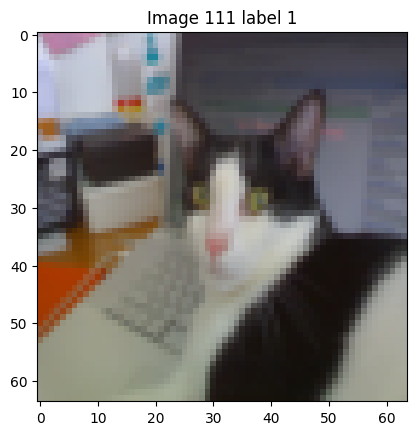

Train X shape: (209, 64, 64, 3)
We have 209 images of dimensionality 64x64x3


In [44]:
# run several times to visualize different data points
# the title shows the ground truth class labels (0=no cat , 1 = cat)

# Pick a random index
index = np.random.randint(low=0,high=train_y.shape[1])

# Show the corresponding image and labelize it
plt.imshow(train_x[index])
plt.title("Image "+str(index)+" label "+str(train_y[0,index]))
plt.show()

# Print data dimension
print ("Train X shape: " + str(train_x.shape))
print ("We have "+str(train_x.shape[0]),
       "images of dimensionality "
       + str(train_x.shape[1])+ "x"
       + str(train_x.shape[2])+ "x"
       + str(train_x.shape[3]))

*Image is a numpy array of 64 by 64, and each element contains the 3 RBG values.*

#### Preprocessing
In the following lines we vectorize the images (Instead of a 2-D image we will give as input to the models a 1-D vector). The normalization makes the image intensities be between 0 and 1, and converts the images to floats.

Pictures are 64 by 64 shaped, moreover, each cases contains 3 values RBG, and we have 209 samples. Thus, $X$ shape is $(209 \times 64 \times 64 \times 3)$. However we would like to have X shaped as $(64\times64\times3=12288, 209)$; to vectorize the data set we write the following code:

In [45]:
train_x, train_y, test_x, test_y, classes=load_dataset(IMDIR)
print ("Original train X shape: " + str(train_x.shape))
print ("Original test X shape: " + str(test_x.shape))
print('')
train_x = train_x.reshape(train_x.shape[0], -1).T
test_x = test_x.reshape(test_x.shape[0], -1).T
print ("Train X shape: " + str(train_x.shape))
print ("Train Y shape: " + str(train_y.shape))
print('')
print ("Test X shape: " + str(test_x.shape))
print ("Test Y shape: " + str(test_y.shape))

Original train X shape: (209, 64, 64, 3)
Original test X shape: (50, 64, 64, 3)

Train X shape: (12288, 209)
Train Y shape: (1, 209)

Test X shape: (12288, 50)
Test Y shape: (1, 50)


Finally we normalized the data to mitigate dominant values.

In [46]:
train_x = train_x/255.
test_x = test_x/255.

print(np.any(train_x>1))

False


### 1. Classification with a single neuron


**a)** We want to implement a single-neuron Neural Network, to do this, we would need the following fucntions:
- A function **initialize_parameters**, which given the number of desired weights ```dim```  inizializes the neuron parameters. Lets denote $m$ the number of dimension of our data; here we have $12228$ dimensions. Thus, we need to create a weight vector shaped $1 \times m$ (1 because we have a single neuron).
> The function will initialize:
> * the model's weights $\mathbf{w}$ by randomly sampling small values from a normal distribution with ```np.random.randn```. $(1\times m)$
> * the bias $b$ with 0. $(1 \times m)$
- A function **sigmoid** that computes the sigmoid activation function: Activation function are used to remove linearities from hidden layer to hidden layer, and focus the wide spray value between 0 and 1.
- A function **neuron** that given an input vector, the weights and bias, computes the output of the single neuron model

In [47]:
def sigmoid(z):
    """
    Activation function.
    Args:
    - z: Output value from the Neuron.
    
    Returns:
    - : Value of the sigmoid function (between 0 and 1).
    """
    return 1/(1+np.exp(-z))

In [88]:
def initialize_parameters(dim):
    """
    Initializing parameters.
    Args:
    - dim: Number of features
    
    Returns:
    - w: Initial weight
    - b: Initial bias
    """
    w = np.random.randn(dim,1) # Normal distribution
    b = 0.
    return w, b

In [89]:
w0,b0 = initialize_parameters(dim=10)
print(w0.shape)

(10, 1)


In [90]:
def neuron(w,b,x):
    """
    Single neuron computation.
    Args:
    - w: Weight vector (numpy array of shape (dim,1))
    - b: Bias (scalar)
    - x: Input vector (numpy array of shape (dim,1))
    
    Returns:
    - a: Output of the neuron after activation (scalar)
    """
    pred_y = np.dot(w.T,x) + b
    return pred_y

**b)** **Forward Pass:**
We compute a first forward pass for the input matrix $X$ containing the loaded dataset, for some initialization of the weights and bias.

 \begin{align}
 Y_{\rm pred}=\sigma(w^\top X+b) = [y_{\rm pred}^{(1)},y_{\rm pred}^{(2)},\dots,y_{\rm pred}^{(m)}]
 \end{align}


In [91]:
m = train_x.shape[0]
print('Problem dimension:', m)
w0, b0 = initialize_parameters(dim=m)

print('w0 shape:', w0.shape)
print('b0 type:',type(b0))

Problem dimension: 12288
w0 shape: (12288, 1)
b0 type: <class 'float'>


In [92]:
output = sigmoid(neuron(w=w0, b=b0, x=train_x))
print('Prediction shape:', output.shape)
print('Prediction:', output)

Prediction shape: (1, 209)
Prediction: [[1.00000000e+00 1.00000000e+00 9.99999830e-01 9.99991873e-01
  3.35428944e-06 9.45116215e-01 9.99966862e-01 6.95396919e-02
  1.00000000e+00 1.00000000e+00 1.00000000e+00 9.97403523e-01
  1.07741658e-02 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.46348157e-08
  9.99962305e-01 9.99999929e-01 1.00000000e+00 1.00000000e+00
  8.93688614e-04 1.00000000e+00 1.00000000e+00 9.99999665e-01
  1.00000000e+00 1.00000000e+00 9.97378051e-01 9.99999980e-01
  1.00000000e+00 9.23463239e-01 1.00000000e+00 4.22712145e-04
  3.09506062e-12 1.00000000e+00 9.66952553e-01 5.24514738e-05
  1.00000000e+00 9.99999997e-01 1.00000000e+00 1.00000000e+00
  1.00000000e+00 7.29799306e-01 4.16892478e-02 9.99999681e-01
  1.00000000e+00 9.99999999e-01 1.00000000e+00 4.40719523e-12
  6.76552253e-01 9.99999824e-01 1.60523038e-11 1.00000000e+00
  9.99999999e-01 3.29556512e-01 1.00000000e+00 9.99999692e-01
  9.99999400e-01 1.00000000e+00

**c) Cost estimation:**

Maximum Likelihood Estimation (MLE) is a statistical methode for estimating the parameters of a probabilistic model. Goal is to find the parameters that maximize the likelihood of the observed data $L(w,b)=\prod_{i=1}^m P(y^{(i)}|x^{(i)};w,b)$. Equivalently we can use the log of this last expression (LLE): $\log(L(w,b))=\sum_{i=1}^m y^{(i)}\log(P(y^{(i)}|x^{(i)}))+(1-y^{(i)})\log(1-P(y^{(i)}|x^{(i)}))$

Thus, Binary cross-entropy loss can be computed as:
$
 \begin{align}
 E = - \frac{1}{m} \sum_{i=1}^m
 y^{(i)} \log(y_{\rm pred}^{(i)}) +
 (1-y^{(i)}) \log(1-y_{\rm pred}^{(i)})
 \end{align}
 $

NB: 
* We put a negative sign, so that now we have to minimize the Cross-entropy; which is equivalent to maximizing MLE
* The $1/m$ is for normalization purpose.

 The following cross-entropy function should give as result the **scalar** cost value computed over the entire dataset

In [94]:
def crossentropy(dim, y_true, y_pred):
    """
    Cross-entropy:
    Args:
    - dim: Number of features - int
    - y_true: Ground-truth, data labels - numpy array (1xn) of {0,1} where n is the number of samples
    - y_pred: Predicted probabilities - numpy array (1xn) of {0,1}
    
    Returns:
    - cost: Cross-entyropy lost - float
    """
    epsilon = 1e-15 
    y_pred = np.clip(y_pred, epsilon, 1-epsilon) # Avoid nan or inf values by clipping value between eps and 1-eps 

    cost = - (1/dim) * sum(np.dot(y_true, np.log(y_pred.T)) + np.dot((1-y_true), np.log(1-y_pred.T)))
    return cost[0]

E = crossentropy(dim=m, y_true=train_y, y_pred=output)
print('Binary Cross-entropy loss:', np.round(E,2))

Binary Cross-entropy loss: 0.22


**d) Back propagation:**

After initializing the parameters and doing a forward pass, we need to backpropagate the cost by computing the gradient with respect to the model parameters to later update the weights.

### Single neuron, 1 layer.

Lets denote $z=w^T+x$ so that the output $y_{pred}=\sigma(z)$. 
1 - We initialize $w$ and $b$ as $w_0$ with a normal distribution, and b to be equal to 0.
2 - Lets do a first forward pass, we have therefore $y_{pred}=\frac{1}{1+e^{w_0x+0}}$, and compare it to $y_true$; we can use cross-entropy, or simplier cost as Squared sum of residual : $\text{SSR} = \frac{1}{2}(y_{pred}-y_{true})^2$. 
3 - Now lets do a backpropagation; we would like to find $w^*$ and $b^*$ that minimize the cost function. To do this, we use a gradient descent methode; we need therefore gradient of cost function respect to w and b. A trick is to use the chain rule, which give us : $\frac{\partial C}{\partial{w}} = \frac{\partial C}{\partial{y_{pred}}} . \frac{\partial y_{pred}}{\partial{z}} . \frac{\partial z}{\partial{w}}$, same $\frac{\partial C}{\partial{b}} = \frac{\partial C}{\partial{y_{pred}}} . \frac{\partial y_{pred}}{\partial{z}} . \frac{\partial z}{\partial{b}}$. Finally, we introduce a learning rate $\alpha$ so that $w_{new} = w - \alpha \frac{\partial C}{\partial{w}}$; $b_{new} = b - \alpha \frac{\partial C}{\partial{b}}$.


**e) Optimization**
After initializing the parameters, computing the cost function, and calculating gradients, we can now update the parameters using gradient descent. Use the functions implemented above to fill_in the "gradient_descent" function that optimizes the parameters given a training set X, Y, a fixed number of iterations, and a learning_rate. Store and plot the value of the loss function at each iteration

In [108]:
def backpropagation(X, y, alpha, num_epochs):
    """
    Perform backpropagation to update weights and bias.
    Args:
    - X: Input data (m, n) where m is the number of features and n is the number of samples
    - y: True labels (1, n)
    - w: Weights (m, 1)
    - b: Bias (scalar)
    - alpha: Learning rate (scalar)
    - num_epochs: Number of training iterations
    
    Returns:
    - w: Updated weights (m, 1)
    - b: Updated bias (scalar)
    """
    m, n = X.shape  # m: number of features, n: number of samples
    costs = []
    w, b = initialize_parameters(m)


    for epoch in range(num_epochs):
        # Forward pass
        z = np.dot(w.T, X) + b  # z: (1, n)
        yh = sigmoid(z)          # predicted y: yh (1, n)
        
        # Compute loss
        loss = crossentropy(dim=m, y_true=y, y_pred=yh)
        costs.append(loss)
        
        # Backward pass
        dz = yh - y
        dw = np.dot(X, dz.T) / n  # dw: (m, 1)
        db = np.sum(dz) / n       # db: Scalar
        
        # Update parameters
        w -= alpha * dw
        b -= alpha * db
        
        # Print the loss every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")
    
    return w, b, costs

w_opt, b_opt, costs = backpropagation(X=train_x, y=train_y, alpha=0.01, num_epochs=2000)

Epoch 0, Loss: 0.314314307433708
Epoch 100, Loss: 0.10724279057660083
Epoch 200, Loss: 0.09236536692499323
Epoch 300, Loss: 0.08092477574716314
Epoch 400, Loss: 0.07041019612716332
Epoch 500, Loss: 0.061351026500390704
Epoch 600, Loss: 0.05352699097656971
Epoch 700, Loss: 0.046736056343665525
Epoch 800, Loss: 0.04113061468424495
Epoch 900, Loss: 0.03635462621093949
Epoch 1000, Loss: 0.03215556374786503
Epoch 1100, Loss: 0.028473737513651433
Epoch 1200, Loss: 0.025293348596332206
Epoch 1300, Loss: 0.02254555979922155
Epoch 1400, Loss: 0.020034317617877877
Epoch 1500, Loss: 0.017669292406859556
Epoch 1600, Loss: 0.01546317694357165
Epoch 1700, Loss: 0.013530773266051309
Epoch 1800, Loss: 0.011853707082373488
Epoch 1900, Loss: 0.01035784518109026


**f) Plot the training loss curve**
We display the evolution of the loss against the iterations

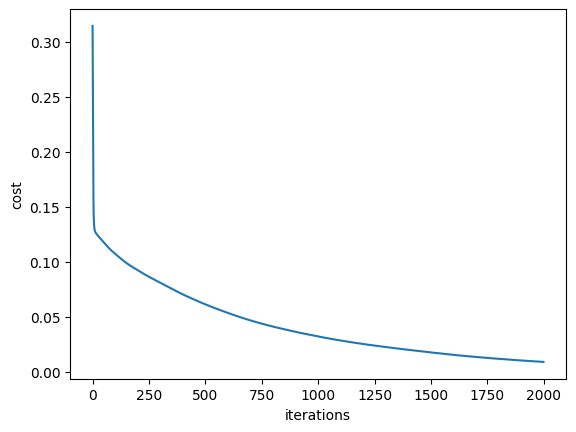

In [111]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

We can see that cost function decrease a lot in the beginning then slowly converge to 0.

**g) Prediction**
Lets test our single neuron Neural Network on the data; and see if we can have good prediction with it.

In [115]:
from sklearn.model_selection import train_test_split

In [116]:
X_train, X_test, y_train, y_test = train_test_split(train_x.T, train_y.T, test_size=0.1, random_state=42)
print(X_train.shape)
print(X_test.shape)

(188, 12288)
(21, 12288)


In [117]:
w_opt, b_opt, costs = backpropagation(X=X_train.T, y=y_train.T, alpha=0.01, num_epochs=2000)

Epoch 0, Loss: 0.15623104487097528
Epoch 100, Loss: 0.06930116997283241
Epoch 200, Loss: 0.05649412375954915
Epoch 300, Loss: 0.047431363521611244
Epoch 400, Loss: 0.04107875623007302
Epoch 500, Loss: 0.03590150610934434
Epoch 600, Loss: 0.031591418887900354
Epoch 700, Loss: 0.027834102358390934
Epoch 800, Loss: 0.02453274489393952
Epoch 900, Loss: 0.02155790363240269
Epoch 1000, Loss: 0.01889745847229396
Epoch 1100, Loss: 0.016568041524337905
Epoch 1200, Loss: 0.014590262853221448
Epoch 1300, Loss: 0.012898216545156604
Epoch 1400, Loss: 0.01138795249561814
Epoch 1500, Loss: 0.010075149511265126
Epoch 1600, Loss: 0.008961738513480937
Epoch 1700, Loss: 0.007993996559407806
Epoch 1800, Loss: 0.007152994540752239
Epoch 1900, Loss: 0.0064173789511247055


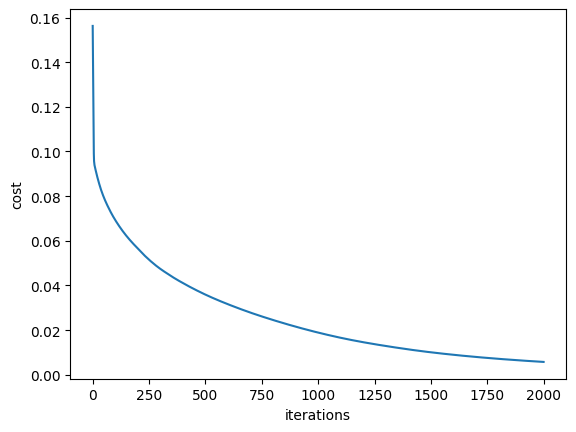

In [118]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

In [121]:
def predict(w, b, X):
    y_pred = sigmoid(np.dot(w.T,X) + b)
    return y_pred

# predict
train_pred_y = predict(w=w_opt, b=b_opt, X=train_x)
test_pred_y = predict(w=w_opt, b=b_opt, X=test_x)
print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y - train_y)) * 100))
print("Test Acc: {} %".format(100 - np.mean(np.abs(test_pred_y - test_y)) * 100))

Train Acc: 84.67722444100525 %
Test Acc: 61.58034856896716 %


Test Accuracy is of course lower than training accuracy, as model as been train with training data. However, we can see that single neuron is not efficient enough to predict correclty the data. We will see in the next part, how to implement complexe Neural Network with python Librairy as TensorFlow or Pycharm.

In [124]:
print(test_y)
print(np.round(test_pred_y,2))

[[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]
[[1.   0.83 1.   1.   1.   1.   0.   1.   0.02 1.   0.   1.   1.   1.
  0.   0.   0.   0.98 0.   0.   0.   0.   1.   1.   0.99 1.   1.   0.
  0.   1.   1.   0.01 1.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.96 0.   1.   1.   0.   1.   1.   0.  ]]
